In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets
from IPython.display import display

from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
# Anzeigeeinstellungen für Pandas
pd.set_option('display.max_colwidth', 200)

In [3]:
features_df = pd.read_csv("nbme-score-clinical-patient-notes/features.csv")
features_df.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [4]:
notes_df = pd.read_csv("nbme-score-clinical-patient-notes/patient_notes.csv")
notes_df.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


In [5]:
submission_df = pd.read_csv("nbme-score-clinical-patient-notes/sample_submission.csv")
submission_df.head()

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


In [6]:
test_data = pd.read_csv("nbme-score-clinical-patient-notes/test.csv")
test_data.head()

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [7]:
train_df = pd.read_csv("nbme-score-clinical-patient-notes/train.csv")
train_df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [8]:
# 3. Merge of the data for better analysis
merged_df = train_df.merge(features_df, on=['feature_num', 'case_num'], how='left') \
                    .merge(notes_df, on=['pn_num', 'case_num'], how='left')

print("Merged Dataset:")
display(merged_df.head())

Merged Dataset:


,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."


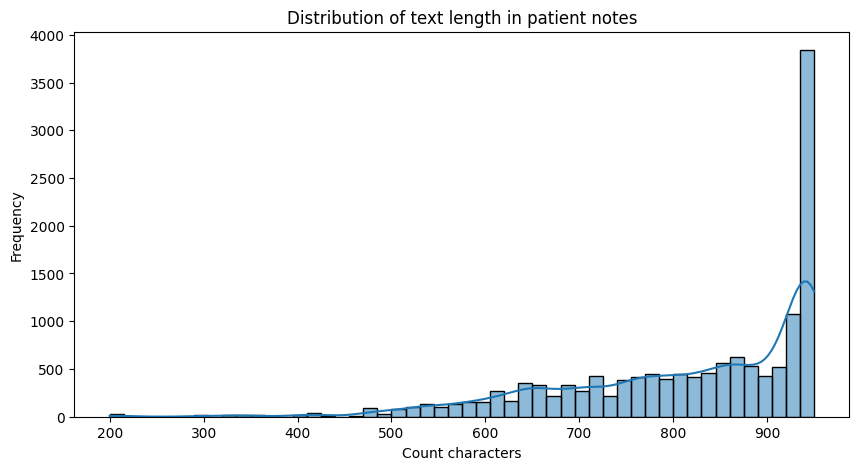

In [9]:
# 4. length of notes
merged_df['note_length'] = merged_df['pn_history'].str.len()
plt.figure(figsize=(10,5))
sns.histplot(merged_df['note_length'], bins=50, kde=True)
plt.title("Distribution of text length in patient notes")
plt.xlabel("Count characters")
plt.ylabel("Frequency")
plt.show()

In [10]:
def get_span_lengths(location_str):
    if pd.isna(location_str):
        return []
    try:
        # Entferne eckige Klammern und Hochkommas
        cleaned = re.sub(r"[\[\]']", "", location_str)
        spans = []
        for part in cleaned.split(';'):
            start_end = part.strip().split()
            if len(start_end) == 2:
                start, end = map(int, start_end)
                spans.append((start, end))
        return spans
    except Exception as e:
        print(f"Fehler bei location '{location_str}': {e}")
        return []

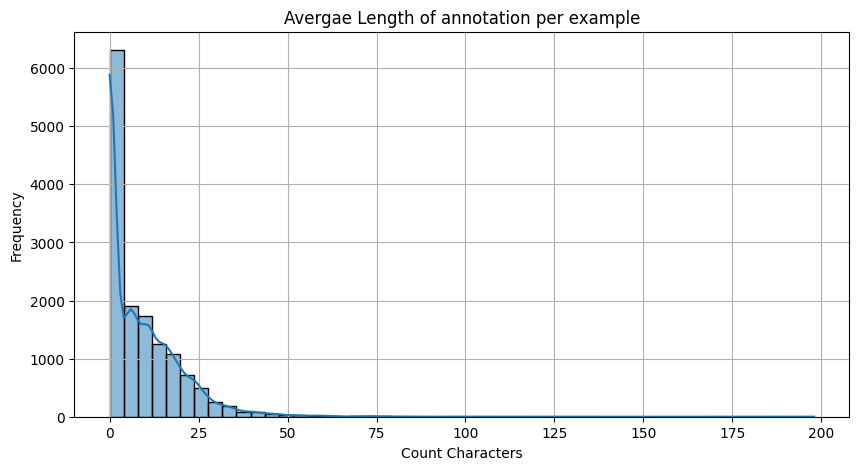

In [11]:
# List of Spannenlängen
merged_df['span_lengths'] = merged_df['location'].apply(
    lambda loc: [b - a for a, b in get_span_lengths(loc)]
)

# Average length of example
merged_df['avg_span_length'] = merged_df['span_lengths'].apply(
    lambda x: sum(x)/len(x) if x else 0
)

# Visualisierung
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['avg_span_length'], bins=50, kde=True)
plt.title("Avergae Length of annotation per example")
plt.xlabel("Count Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

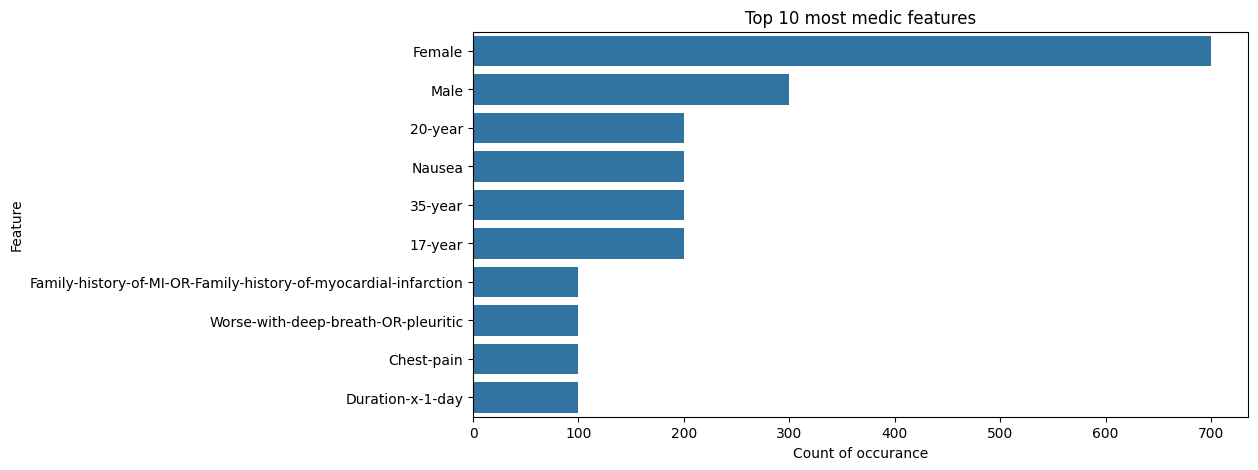

In [12]:
# 5. most medic features
top_features = merged_df['feature_text'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 most medic features")
plt.xlabel("Count of occurance")
plt.ylabel("Feature")
plt.show()

In [13]:
# 6. Visualization of a Text with Lables
example = merged_df.iloc[0]
print(f"\nPatient Note:\n{example['pn_history']}")
print(f"\nMarked Feature: {example['feature_text']}")
print(f"Position in text: {example['location']}")

locations = example['location']

if pd.notna(locations):
    # Entferne eckige Klammern und evtl. Anführungszeichen
    cleaned = re.sub(r"[\[\]']", "", locations)
    
    # Split auf ;
    spans = cleaned.split(';')
    
    for span in spans:
        try:
            start, end = map(int, span.strip().split())
            snippet = example['pn_history'][start:end]
            print(f"- {start} {end}: '{snippet}'")
        except Exception as e:
            print(f"Error while parsing '{span}': {e}")
else:
    print("No postion available.")


Patient Note:
HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms

Marked Feature: Family-history-of-MI-OR-Family-hist

In [14]:
# 7. Check on missing values
print("\nMissing values:")
display(merged_df.isnull().sum())


Missing values:


id                 0
case_num           0
pn_num             0
feature_num        0
annotation         0
location           0
feature_text       0
pn_history         0
note_length        0
span_lengths       0
avg_span_length    0
dtype: int64

In [15]:
# 8. Check on duplicates
print("\nAmount douplicates (train.csv):", train_df.duplicated().sum())


Amount douplicates (train.csv): 0


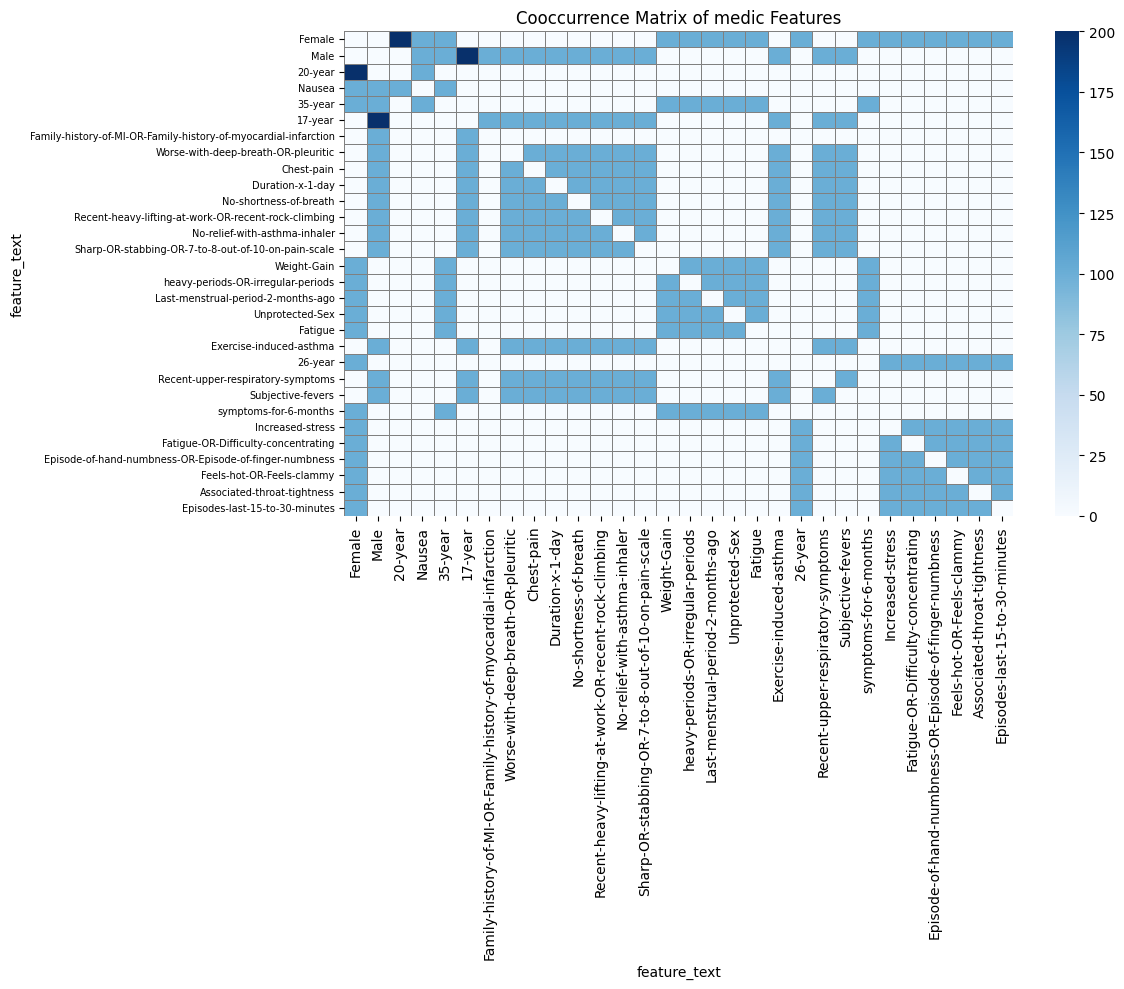

In [16]:
import numpy as np

# 1. Feature-Liste pro Patientennotiz erstellen
feature_sets = merged_df.groupby('pn_num')['feature_text'].apply(set)

# 2. Alle Features
all_features = sorted(set(merged_df['feature_text']))
feature_to_idx = {f: i for i, f in enumerate(all_features)}

# 3. Leere Kookkurrenzmatrix erstellen
co_matrix = np.zeros((len(all_features), len(all_features)), dtype=int)

# 4. Matrix füllen
for features in feature_sets:
    indices = [feature_to_idx[f] for f in features if f in feature_to_idx]
    for i in indices:
        for j in indices:
            if i != j:
                co_matrix[i, j] += 1

# 5. Als DataFrame für Heatmap
co_df = pd.DataFrame(co_matrix, index=all_features, columns=all_features)

# 6. Optional: nur häufige Features visualisieren (z. B. top 30)
top_features = merged_df['feature_text'].value_counts().head(30).index
co_df_subset = co_df.loc[top_features, top_features]

# 7. Heatmap zeichnen
plt.figure(figsize=(12, 10))
sns.heatmap(co_df_subset, cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Cooccurrence Matrix of medic Features")
plt.xticks(rotation=90)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

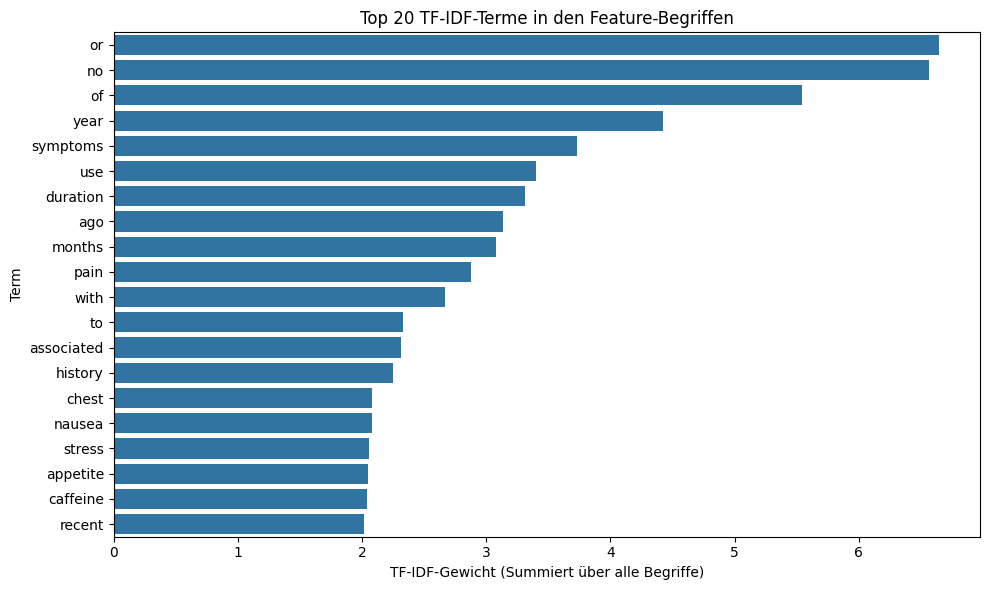

In [17]:
# Einmalige Liste der Begriffe
feature_texts = merged_df['feature_text'].dropna().unique()

# TF-IDF-Vektorizer anwenden (auf Tokenebene)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(feature_texts)

# TF-IDF-Werte aufsummieren je Token
tfidf_scores = X.sum(axis=0).A1  # Array mit Summe je Token
terms = vectorizer.get_feature_names_out()

# In DataFrame überführen
tfidf_df = pd.DataFrame({'term': terms, 'tfidf_sum': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

# Top 20 Begriffe visualisieren
plt.figure(figsize=(10, 6))
sns.barplot(data=tfidf_df.head(20), x='tfidf_sum', y='term')
plt.title("Top 20 TF-IDF-Terme in den Feature-Begriffen")
plt.xlabel("TF-IDF-Gewicht (Summiert über alle Begriffe)")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

In [18]:
# 1. Nur relevante Spalten
label_text_df = merged_df[['feature_text', 'pn_history']].dropna()

# 2. Gruppieren: Alle Texte zu einem Feature zusammenführen
grouped = label_text_df.groupby('feature_text')['pn_history'].apply(lambda texts: ' '.join(texts))

# 3. TF-IDF über den gruppierten Text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(grouped)

# Ergebnis-Matrix: labels × tokens
tfidf_df = pd.DataFrame(X.toarray(), index=grouped.index, columns=vectorizer.get_feature_names_out())

In [24]:
# Alle eindeutigen Feature-Bezeichnungen holen
feature_list = sorted(merged_df['feature_text'].dropna().unique())

# Mit Index ausgeben
for idx, label in enumerate(feature_list):
    print(f"[{idx}] {label}")

[0] 1-day-duration-OR-2-days-duration
[1] 17-year
[2] 2-to-3-beers-a-week
[3] 20-year
[4] 26-year
[5] 35-year
[6] 44-year
[7] 45-year
[8] 67-year
[9] 8-to-10-hours-of-acute-pain
[10] Adderall-use
[11] Associated-SOB-OR-Associated-shortness-of-breath
[12] Associated-feeling-of-impending-doom
[13] Associated-nausea
[14] Associated-throat-tightness
[15] Auditory-hallucination-once
[16] Awakens-at-night
[17] Caffeine-use
[18] Chest-pain
[19] Chest-pressure
[20] Darker-bowel-movements
[21] Decreased-appetite
[22] Difficulty-falling-asleep
[23] Difficulty-with-sleep
[24] Diminished-appetite
[25] Diminished-energy-OR-feeling-drained
[26] Duration-x-1-day
[27] Early-wakening
[28] Epigastric-discomfort
[29] Episode-of-hand-numbness-OR-Episode-of-finger-numbness
[30] Episodes-last-15-to-30-minutes
[31] Episodes-of-heart-racing
[32] Exercise-induced-asthma
[33] FHx-of-PUD-OR-Family-history-of-peptic-ulcer-disease
[34] FHx-of-depression-OR-Family-history-of-depression
[35] Family-history-of-MI-OR-

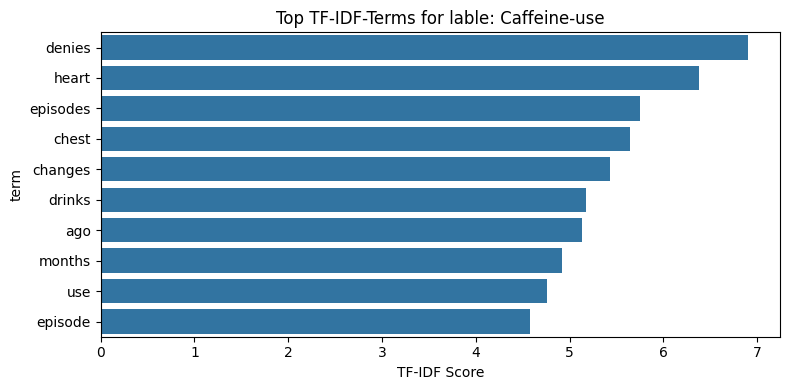

In [26]:
# Label auswählen – verwende hier den exakten Text
label = feature_list[17]

# Alle Notizen zum Label holen
texts = merged_df[merged_df['feature_text'] == label]['pn_history'].dropna().tolist()

# Falls keine Notizen vorhanden
if not texts:
    print(f"No Texts for Label '{label}' found.")
else:
    # TF-IDF über die zugehörigen Notizen
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    # TF-IDF-Werte sortieren und anzeigen
    tfidf_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_scores})
    top_terms = tfidf_df.sort_values(by='tfidf', ascending=False).head(10)

    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_terms['tfidf'], y=top_terms['term'])
    plt.title(f"Top TF-IDF-Terms for lable: {label}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()

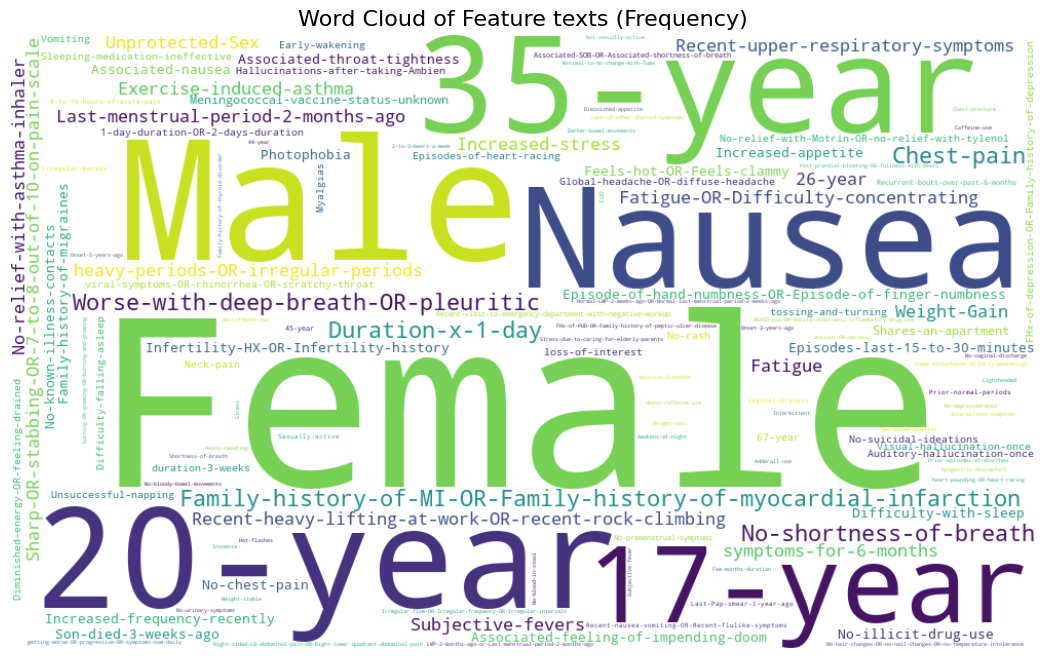

In [29]:
# 1. Häufigkeit der Feature-Begriffe zählen
feature_counts = merged_df['feature_text'].value_counts()

# 2. WordCloud erzeugen
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(feature_counts)

# 3. Anzeigen
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Feature texts (Frequency)", fontsize=16)
plt.show()

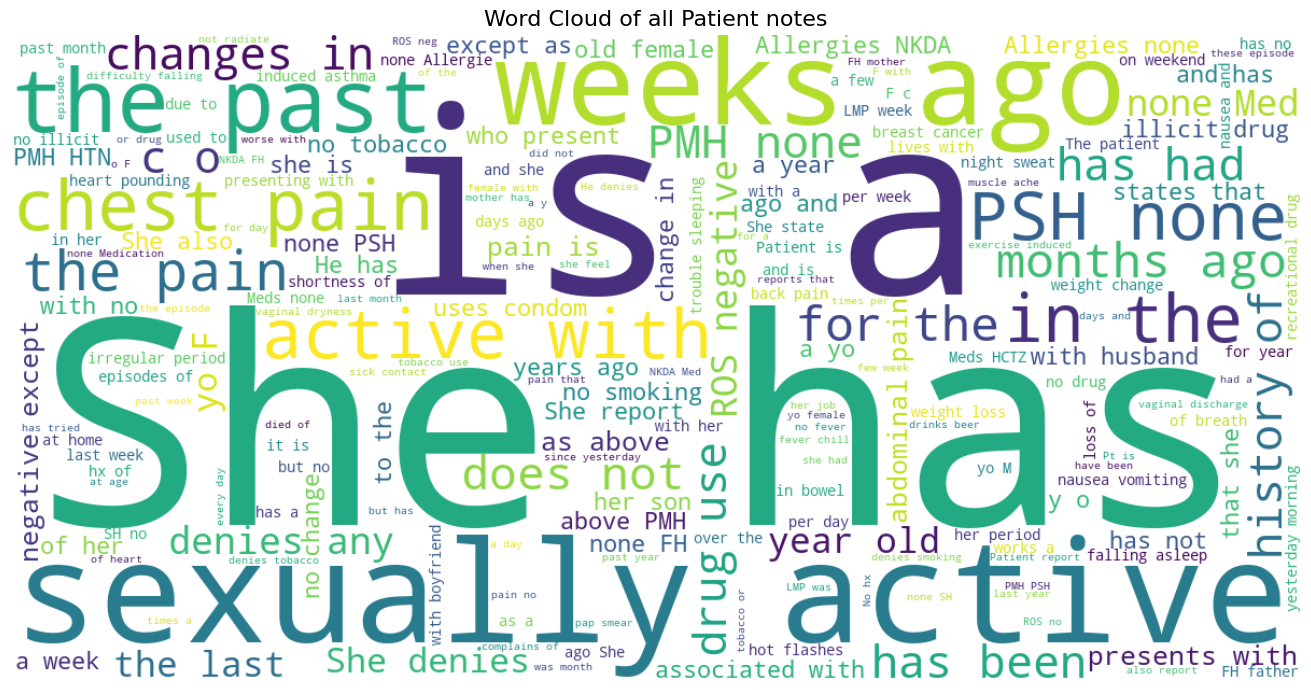

In [31]:
# 1. Alle Patientennotizen zu einem Text vereinen
text_corpus = ' '.join(merged_df['pn_history'].dropna())

# 2. Word Cloud generieren
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords='english',  # englische Stopwords automatisch ausschließen
    max_words=200,
    colormap='viridis'
).generate(text_corpus)

# 3. Anzeigen
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of all Patient notes", fontsize=16)
plt.tight_layout()
plt.show()